# 기본 시각화 및 전처리
데이터 가져와서 결측값 삭제하고 자료형 변환  
이후 연도별 Frequency를 시각화

In [1]:
# 아래 코드는 윈도우 기준임.
# 타 OS에서는 정상작동을 보장하지 않으니 확인 요함.

import datetime as dt
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as dtparser

import utils

plt.rc('font', family="Malgun Gothic")

In [2]:
# 결과 파일들의 파일명과 검색 키워드를 딕셔너리에 저장.
# 순회해서 데이터를 쉽게 불러오기 위한 작업임.

# 파일 종류를 저장하는 문자열 리스트
source_types = ["news_api", "news_crawl", "kin", "news_unique", "kin_unique"]

# keywords["파일종류 문자열"]: 해당 파일종류가 가지고 있는 키워드들의 리스트.
# 병합, 중복제거, 토큰화 결과(news_unique)는 키워드가 없으므로 빈 문자열을 키워드로 함.
keywords = {}
keywords["kin"] = ["환자 권리", "환자 요구", "환자 의견"]
keywords["news"] = []
keywords["news_api"] = ["환자-의사 공유 의사결정"]
keywords["news_crawl"] = ["환자 의사 공유의사결정"]
keywords["news_unique"] = [""]
keywords["kin_unique"] = [""]

# filenames["파일종류 문자열"]: 해당 파일종류의 실제 파일명.
filenames = {}
filenames["kin"] = utils.FileType.KIN_WT.value
filenames["news"] = ""
filenames["news_api"] = utils.FileType.NEWS_WT.value
filenames["news_crawl"] = utils.FileType.CRAWL_NEWS_WT.value
filenames["news_unique"] = utils.FileType.NEWS_PROCESSED_UNIQUE.value
filenames["kin_unique"] = utils.FileType.KIN_PROCESSED_UNIQUE.value


In [3]:
# 실제로 데이터프레임을 로드함.
# dfs["파일종류 문자열"]["키워드 문자열"]: 파일종류와 키워드가 지정된 데이터프레임.
# e.g. dfs["news_crawl"]["환자 의사 공유의사결정"]은 "환자 의사 공유의사결정" 검색어로 검색해서 크롤링으로 수집한 뉴스 데이터프레임.

dfs = {}
for source_type in source_types:
    dfs[source_type] = {}
    for keyword in keywords[source_type]:
        filename = f'{filenames[source_type]}_{keyword}.txt' if keyword else f'{filenames[source_type]}.txt'
        data_json = utils.get_json_from_file(filename)["items"]
        dfs[source_type][keyword] = pd.DataFrame(data_json)


# 데이터프레임 가공 및 전처리.

# 지식인 데이터 전처리를 위한 함수
def dtparse(s: str) -> None | dt.datetime :
    """
    지식인 데이터에서 문자열을 dt객체로 파싱하는 함수.
    파싱에 실패하면 None 반환.

    Args:
        s (str): 날짜를 나타낼 것으로 추측되는 문자열.

    Returns:
        None | dt.datetime: 파싱이 성공하면 dt객체, 실패하면 None.
    """
    if s.startswith("작성일"):
        s = s[3:]
    try:
        return dtparser.parse(s)
    except dtparser.ParserError:
        return None


# 네이버 뉴스 api 데이터.
# 날짜를 dt객체로 변경.
# 에러로 인해 수집되지 않은 데이터 드롭.
source_type = "news_api"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["date"] = pd.to_datetime(df["date"])
    df = df[~df["text"].str.endswith("_error")]
    dfs[source_type][keyword] = df


# 네이버 뉴스 크롤링 데이터.
# 날짜를 dt객체로 변경.
# 에러로 인해 수집되지 않은 데이터 드롭.
source_type = "news_crawl"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["date"] = pd.to_datetime(df["date"])
    df = df[~df["text"].str.endswith("_error")]
    dfs[source_type][keyword] = df


# 네이버 지식인 데이터.
# 날짜를 나타내는 "지저분한" 문자열을 dt객체로 변경.
source_type = "kin"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["date"] = df["date"].apply(lambda x: list(map(dtparse, x)))
    dfs[source_type][keyword] = df


# 중복을 제거하고 토큰화한 뉴스 데이터.
# api와 크롤링에서 날짜 형식이 달라서 통일하고 dt객체로 반환.
# 토큰이 없는 데이터 드롭.
# TODO: 별로 깔끔한 방식은 아님. 리팩토링 요함.
# 1. 수집 때부터 날짜 양식을 맞추도록 수정할 것.
# 2. .ipynb 파일을 분리해서 전처리부와 시각화부를 나눌 것.
source_type = "news_unique"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["date"] = df["date"].apply(lambda x: pd.to_datetime(x).tz_localize(None))
    df["date"] = pd.to_datetime(df["date"])
    df = df[df["tokens"].apply(lambda x: len(x) > 0)]
    dfs[source_type][keyword] = df


# 중복을 제거하고 토큰화한 지식인 데이터.
# 데이터프레임에서 질문, 답변을 분리하여 정규화.
# 기존 인덱스를 id로 삼아서 질문과 답변의 연결을 유지
# 이후 질문 데이터프레임과 답변 데이터프레임을 연결(concat).
# 날짜를 나타내는 "지저분한" 문자열을 dt객체로 변경.
source_type = "kin_unique"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword].copy()
    df = df[df["date"].apply(lambda x: len(x) > 0)]
    df["id"] = df.index

    df_question = df.copy()
    df_question["date"] = df["date"].apply(lambda x: x.pop(0))
    df_question.drop(columns=["tokens_answer", "answers"], inplace=True)
    df_question.rename({"question": "text"}, axis="columns", inplace=True)
    df_question["type"] = "question"

    df_answer = df.explode(column=["answers", "date", "tokens_answer"], ignore_index=True)
    df_answer.drop(columns=["tokens", "question"], inplace=True)
    df_answer.rename({"tokens_answer": "tokens", "answers": "text"}, axis="columns", inplace=True)
    df_answer["type"] = "answer"

    df = pd.concat([df_question, df_answer])
    df["date"] = df["date"].apply(dtparse)
    dfs[source_type][keyword] = df.copy()

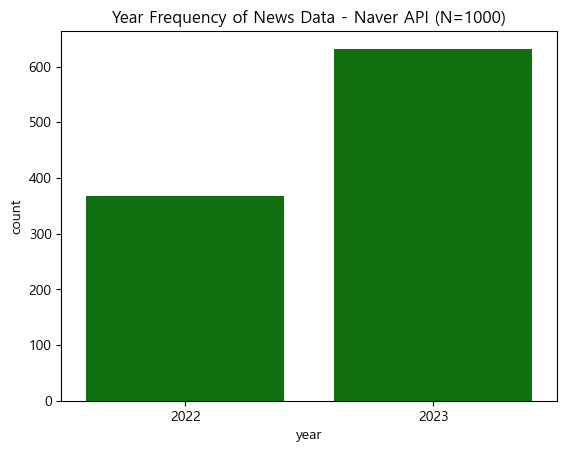

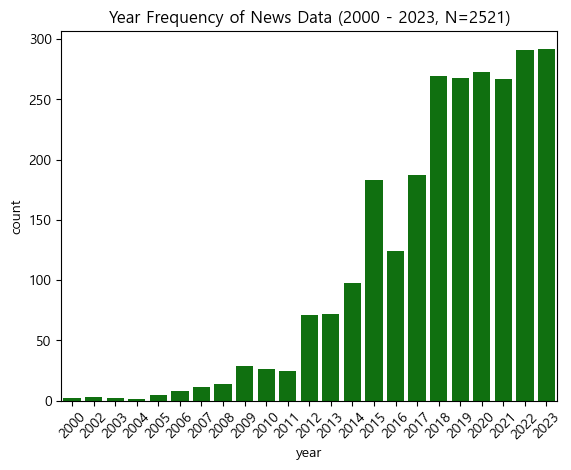

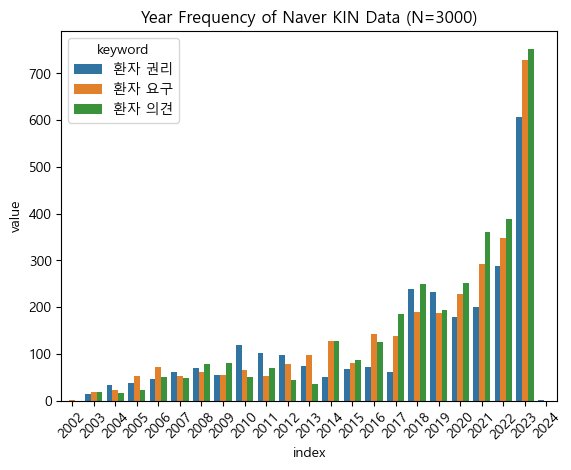

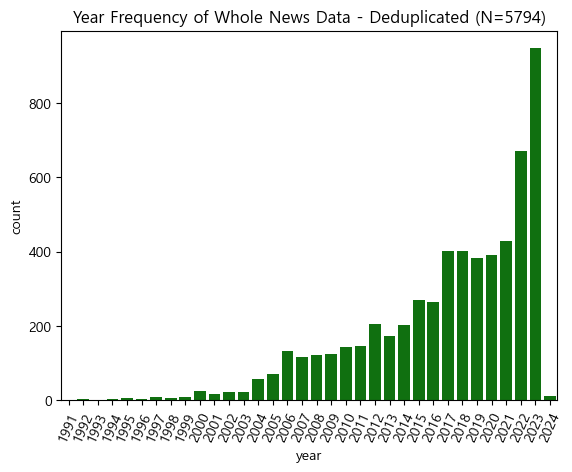

In [ ]:
# Year Frequency 시각화
# TODO: 시각화와 전처리를 다른 파일로 분리하고, 각 파일타입별로 셀을 분리.

# 네이버 뉴스 api 데이터.
# 연도를 뽑아내고 연도별 countplot 플로팅.
source_type = "news_api"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["year"] = df["date"].dt.year
    sns.countplot(data=df, x="year", color="green")
    plt.title(f"Year Frequency of News Data - Naver API (N={len(df)})")
    plt.show()

# 네이버 뉴스 크롤링 데이터.
# 연도를 뽑아내고 연도별 countplot 플로팅.
source_type = "news_crawl"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["year"] = df["date"].dt.year
    sns.countplot(data=df, x="year", color="green")
    plt.title(f"Year Frequency of News Data (2000 - 2023, N={len(df)})")
    plt.xticks(rotation=45)
    plt.show()

# 네이버 지식인 데이터.
# 전체 n을 세고, 년도를 기록함.
# 이후 해당 데이터를 이용해 barplot 플로팅.
# TODO: 리팩토링 요함.
# 1. 전처리 과정 등에서 데이터 concat 필요.
# 2. 각 파일에 별도로 접근해야 하는 경우를 대비해 keyword 열을 생성.
source_type = "kin"
temp_n = 0
year_dict = dict(zip(keywords[source_type], [defaultdict(int) for _ in keywords[source_type]]))
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    temp_n += len(df)
    for row in df["date"]:
        for date in row:
            if date is None:
                continue
            year_dict[keyword][date.year] += 1

df_temp = pd.melt(pd.DataFrame(year_dict).reset_index(), id_vars='index', var_name='column', value_name='value')
sns.barplot(data=df_temp, x='index', y='value', hue='column')
plt.title(f"Year Frequency of Naver KIN Data (N={temp_n})")
plt.xticks(rotation=45)
plt.legend(title = "keyword")
plt.show()

# 중복을 제거하고 토큰화한 뉴스 데이터.
# 연도를 뽑아내고 연도별 countplot 플로팅.
source_type = "news_unique"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["year"] = df["date"].dt.year
    sns.countplot(data=df, x="year", color="green")
    plt.title(f"Year Frequency of Whole News Data - Deduplicated (N={len(df)})")
    plt.xticks(rotation=66)
    plt.show()

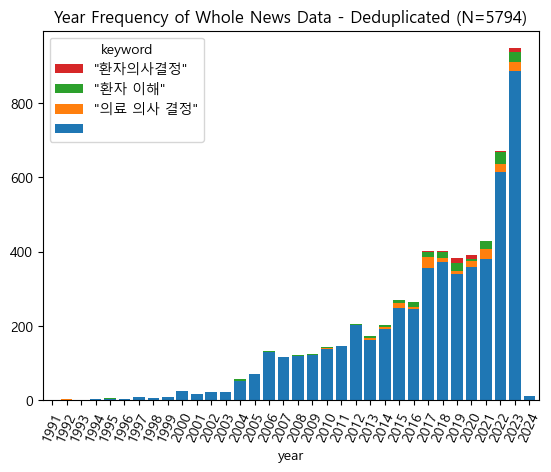

In [ ]:
# 각 키워드 별 기사 빈도 플로팅.
source_type = "news_unique"
for keyword in keywords[source_type]:
    df = dfs[source_type][keyword]
    df["year"] = df["date"].dt.year
    df = df[["year", "keyword"]]
    df_count = df.value_counts().unstack().fillna(0)

    df_count.plot.bar(stacked=True, legend="reverse", width=0.8)
    plt.title(f"Year Frequency of Whole News Data - Deduplicated (N={len(df)})")
    plt.xticks(rotation=66)
    plt.show()

# 토픽 모델링
BERTopic으로 Hierarchical Topic Modeling 수행.

In [5]:
# mecab 모듈의 경우 python-mecab-ko 모듈을 사용함.
# 이 모듈이 느리기 때문에, 성능개선을 위해서는 다른 토크나이저를 사용하도록 할 수 있음.

import re
from itertools import chain
from typing import List

from bertopic import BERTopic
from mecab import MeCab
from sklearn.feature_extraction.text import CountVectorizer

import utils

d:\Codes\SDM_crawl\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# 네이버 뉴스 토픽모델링으로 유관 데이터 분석.
# TODO: 전처리, 시각화, 토픽모델링을 각 파일로 분리.
typestring = input('대상 데이터 종류 선택("news" | "kin")')
serial_version = input('불러올 모델 선택("v1", "v2", ..., 빈칸이면 새로 학습)')


df = dfs[f"{typestring}_unique"][""]
n = len(df)
mecab = MeCab()

# 사용중인 토크나이저의 성능 이슈 때문에, 문서 별로 이미 캐시된 토큰화 결과를 그대로 사용함.
# betopic에서 토큰화를 수행할 때, 문서들을 concat해서 수행하는데, 문서 단위의 토큰화 결과는 동일하므로, 이를 재사용하는 게 목적.
# deli: concat한 문서를 다시 분리하기 위한 구분자(delimeter)임. 원본 문서들에 없는 문자열이면 무엇이든 사용 가능.
# token_map["문서내용"]: 해당 문서내용의 토큰화 결과
deli = "$!$!$!"
token_map = dict(zip(
    df["text"].apply(lambda x: re.sub(r"\s", "", x).lower()), 
    df["tokens"]
))
token_map[""] = []

# 불용어를 일일히 설정하는 대신 길이가 1인 토큰은 전부 드랍.
# 추가로 필요하면 vectorizer에 불용어 추가 가능하니 추가하면 됨.
for key, val in token_map.items():
    token_map[key] = list(filter(lambda x: len(x) >= 2, val))

def tokenize_nouns(text: str) -> List[str]:
    """
    캐시된 문서의 토큰 목록을 반환.

    Args:
        text (str): 문서 내용 전체.

    Returns:
        List[str]: 해당 문서의 토큰화 결과 리스트.
    """
    texts = text.split(deli)
    rets = list(chain.from_iterable([token_map[re.sub("(\s|\\xa0)", "", text)] for text in texts]))
    return rets

vectorizer = CountVectorizer(tokenizer=tokenize_nouns)

# 추후 연결된 문서를 분리하기 위해 문서의 끝에 구분자를 삽입.
docs = df["text"].copy()
for i in docs.index:
    docs[i] += deli

if serial_version:
    # 직렬화한 토픽모델링 결과 로드.
    topic_model = BERTopic.load(f"{utils.MATERIALS}/bertopic_filter_{typestring}_{serial_version}")
    topic_model.vectorizer_model = vectorizer
    topic_model.language = "multilingual"
else:
    # 토픽모델링 수행.
    topic_model = BERTopic(verbose=True, language="multilingual", vectorizer_model=vectorizer)
    topics, probs = topic_model.fit_transform(docs)

2024-02-08 05:28:44,264 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 237/237 [23:22<00:00,  5.92s/it]
2024-02-08 05:52:13,852 - BERTopic - Embedding - Completed ✓
2024-02-08 05:52:13,855 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-08 05:52:54,215 - BERTopic - Dimensionality - Completed ✓
2024-02-08 05:52:54,233 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-08 05:52:54,761 - BERTopic - Cluster - Completed ✓
2024-02-08 05:52:54,814 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-08 05:52:57,102 - BERTopic - Representation - Completed ✓


In [ ]:
# 모델 직렬화하여 저장.

v = 1
while True:
    if not utils.already(f"{utils.MATERIALS}/bertopic_filter_{typestring}_v{v}"):
        break
    v += 1

embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save(f"{utils.MATERIALS}/bertopic_filter_{typestring}_v{v}", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)


# 수동으로 연관된 것으로 판단되는 토픽 번호를 뽑아서 데이터 저장.
# Cortext에 사용을 용이하게 하기 위해 토큰에 구분자 "***" 삽입.

related_topic_nums = map(int, input('연관된 토픽 번호 입력(구분자: 띄어쓰기)').split())
t = topic_model.get_document_info(docs)
df_filtered = t[t["Topic"].isin(related_topic_nums)]
df_filtered["Tokens"] = df_filtered["Document"].apply(lambda x: '***'.join(tokenize_nouns(x.lower())))
df_filtered.to_csv(f"{utils.RESULTS}/naver_news_filtered_df_v3.csv")

In [21]:
# 토픽 정보를 확인하거나 계층적 토픽에 대한 덴드로그램을 그림.

# 정보 확인, 시각화.
# topic_model.get_topic_info()
# topic_model.visualize_topics()

# 덴드로그램.
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)


100%|██████████| 48/48 [00:00<00:00, 113.04it/s]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [백신_접종_코로나_바이러스_사망, , , 에이즈_감염_염인_바이러스_모기],
              'type': 'scatter',
              'x': array([0.        , 0.89179519, 0.89179519, 0.        ]),
              'xaxis': 'x',
              'y': array([ -5.,  -5., -15., -15.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [자궁_불출석_임신_근종_적출, , , 담배_보건소_친구_문자_금연],
              'type': 'scatter',
              'x': array([0.        , 0.96153339, 0.96153339, 0.        ]),
              'xaxis': 'x',
              'y': array([-25., -25., -35., -35.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [백신_접종_코로나_감염_에이즈, , , 담배_보건소_친구_문자_금연],
              'type': 'scatter',
              'x': array([0.89179519, 0.9898447 , 0.9898447 , 0.96153339]),
              'xaxis': 'x',
              'y': array([-10., -10., -30., -30.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'text': [불면증_발작_수면제_공황_현증, , , 우울증_심리_정신_우울_강박],
              'type': 'scatter',
              'x': array([0.        , 0.64969028, 0.64969028, 0.        ]),
              'xaxis': 'x',
              'y': array([-55., -55., -65., -65.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'text': [우울증_심리_정신_우울_강박, , , 치매_뇌전증_발작_기억력_지력],
              'type': 'scatter',
              'x': array([0.64969028, 0.73670292, 0.73670292, 0.        ]),
              'xaxis': 'x',
              'y': array([-60., -60., -75., -75.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'text': [트랜_성욕_여자_욕구_남자, , , 우울증_정신_심리_장애_우울],
              'type': 'scatter',
              'x': array([0.        , 0.90100752, 0.90100752, 0.73670292]),
              'xaxis': 'x',
              'y': array([-45. , -45. , -67.5, -67.5]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(0,116,217)'},
              'mode': 'lines',
              'text': [담배_백신_보건소_친구_접종, , , 우울증_정신_심리_장애_증상],
              'type': 'scatter',
              'x': array([0.9898447 , 1.09567292, 1.09567292, 0.90100752]),
              'xaxis': 'x',
              'y': array([-20.  , -20.  , -56.25, -56.25]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(35,205,205)'},
              'mode': 'lines',
              'text': [얼굴_광대뼈_수술_광대_축소, , , 돌출_교정_수술_치아_치과],
              'type': 'scatter',
              'x': array([0.        , 0.59025553, 0.59025553, 0.        ]),
              'xaxis': 'x',
              'y': array([-85., -85., -95., -95.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(35,205,205)'},
              'mode': 'lines',
              'text': [돌출_수술_교정_치아_치과, , , 치과_플란트_교정_비용_치아],
              'type': 'scatter',
              'x': array([0.59025553, 0.70780674, 0.70780674, 0.        ]),
              'xaxis': 'x',
              'y': array([ -90.,  -90., -105., -105.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(0,116,217)'},
              'mode': 'lines',
              'text': [담배_친구_백신_보건소_사람, , , 돌출_수술_교정_치아_치과],
              'type': 'scatter',
              'x': array([1.09567292, 1.2212894 , 1.2212894 , 0.70780674]),
              'xaxis': 'x',
              'y': array([-38.125, -38.125, -97.5  , -97.5